<a href="https://colab.research.google.com/github/Mjboothaus/rewarding-risk/blob/main/ASX_SharePriceViewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASX Share Price Viewer - Prototyping

_For MM app - colloboration between EGB and MJB._

## 1. Setup notebook

Note that on the Google Colab platform some Python libraries are pre-installed by default. Such libraries are pre-installed (in the Google Colab environment) and can just be imported.

In [ ]:
import altair as alt      # charting
import pandas as pd       # 2-d arrays of data
import requests           # making http (web) requests   
import json               # working with JSON formatted data
from pathlib import Path  # working with files/paths nicely

The `data_table` package is to enable a prettier and interactive display of Pandas dataframes.

The `files` module allows reading/writing files to the local file system (e.g. the laptop you're using).

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

from google.colab import files

Other libraries need to be installed, typically using the [`pip install`](https://pip.pypa.io/en/stable/getting-started/) command line tool. To run command line tools from within the (Jupyter) notebook environment you need to prefix the command with `!`. Note that these libraries will persist for the duration of the Google Colab session (i.e. if you re-run the installer it will just report that the package(s) is already installed.)

In [ ]:
!pip install yahooquery
!pip install mplfinance

Such libraries still need to be imported before use (after they have been installed using `pip`).

In [ ]:
from yahooquery import Ticker

# Documentation: https://yahooquery.dpguthrie.com/guide/ticker/historical/

import mplfinance as mpf

# Documentation: https://github.com/matplotlib/mplfinance

## 2. Get and verify data 

We need to establish:
* what data we need to solve the problem
* where we can source the data from
* what (if any) are the terms of use (for each data source)
* have we obtained the data correctly ("reasonableness testing")

### What data do we need?

A list of companies in the [ASX 200](https://en.wikipedia.org/wiki/S%26P/ASX_200) index and their corresponding symbol (code/ticker); this includes their market capitalisation (i.e. how much they are worth) which defines which companies are in the index. While this can and does change through time, changes to the composition of the index are typically slow.

We also what market data and Yahoo Finance seeems to provide this information for free - someone has developed the `yahooquery` package that seems reasonable to use - but we should try and verify this!

#### ASX 200 - Index composition data

This data set provided by the ASX is updated daily (or maybe the day following trading days).

In [ ]:
ASX_TICKERS_URL = "https://www.asx.com.au/asx/research/ASXListedCompanies.csv"

We can look at the first $n$ lines of the file using the `curl` and `head` commands in Unix (command line). Remember that the `!` character tells the notebook to execute the command "externally".

_To read about the "Unix command line" often also called the shell - see this [Intro to Bash](https://programminghistorian.org/en/lessons/intro-to-bash)._

In [ ]:
!curl -s "$ASX_TICKERS_URL" | head -n 10

ASX listed companies as at Tue Jan 11 12:12:11 AEDT 2022

Company name,ASX code,GICS industry group
"MOQ LIMITED","MOQ","Software & Services"
"1414 DEGREES LIMITED","14D","Capital Goods"
"1ST GROUP LIMITED","1ST","Health Care Equipment & Services"
"29METALS LIMITED","29M","Materials"
"333D LIMITED","T3D","Commercial & Professional Services"
"360 CAPITAL ENHANCED INCOME FUND","TCF","Not Applic"
"360 CAPITAL GROUP","TGP","Real Estate"


We can see that this file has a header line i.e. "ASX listed companies as at..." so we need to skip this row. We also observe that the fields provided in this file are: `Company name`, three letter `ASX code` and the [`GICS industry group`](https://www.msci.com/our-solutions/indexes/gics) classification.

In [ ]:
asx_tickers_df = pd.read_csv(ASX_TICKERS_URL, skiprows=1)

In [ ]:
asx_tickers_df

,Company name,ASX code,GICS industry group
0,MOQ LIMITED,MOQ,Software & Services
1,1414 DEGREES LIMITED,14D,Capital Goods
2,1ST GROUP LIMITED,1ST,Health Care Equipment & Services
3,29METALS LIMITED,29M,Materials
4,333D LIMITED,T3D,Commercial & Professional Services
...,...,...,...
2259,ZINC OF IRELAND NL,ZMI,Materials
2260,ZIP CO LIMITED.,Z1P,Diversified Financials
2261,ZOOM2U TECHNOLOGIES LIMITED,Z2U,Transportation
2262,ZOONO GROUP LIMITED,ZNO,Materials


Let's also look at the end (`tail`) of the file to see that it looks reasonable (i.e. is not obviously corrupt).

In [ ]:
!curl -s "$ASX_TICKERS_URL" | tail -n 10

"ZETA RESOURCES LIMITED","ZER","Not Applic"
"ZEUS RESOURCES LIMITED","ZEU","Energy"
"ZICOM GROUP LIMITED","ZGL","Capital Goods"
"ZIMI LIMITED","ZMM","Technology Hardware & Equipment"
"ZIMPLATS HOLDINGS LIMITED","ZIM","Materials"
"ZINC OF IRELAND NL","ZMI","Materials"
"ZIP CO LIMITED.","Z1P","Diversified Financials"
"ZOOM2U TECHNOLOGIES LIMITED","Z2U","Transportation"
"ZOONO GROUP LIMITED","ZNO","Materials"
"ZULEIKA GOLD LIMITED","ZAG","Materials"


**EGB - TODO: Have a think about some reasonableness checks / tests for the data. i.e. to see that it makes good sense before we go using it and asking others to trust our application.** 

If you put a semi-colon after a piece of code in a notebook it suppresses the output. In the following example the output from the Pandas dataframe `asx_tickers_df` is suppressed.

In [ ]:
asx_tickers_df;

Utility functions

We try and create (define) functions that will be useful and get re-used throughout the code to make it more readable.

For example, the following function is designed to lookup the full company name from the ASX code.

In [ ]:
asx_tickers_df["ASX code"]

0       MOQ
1       14D
2       1ST
3       29M
4       T3D
       ... 
2259    ZMI
2260    Z1P
2261    Z2U
2262    ZNO
2263    ZAG
Name: ASX code, Length: 2264, dtype: object

In [ ]:
def lookup_company_name(asx_code):
  asx_code = asx_code.replace(".AX", "")
  return asx_tickers_df[asx_tickers_df["ASX code"] == asx_code]["Company name"].to_list()[0].title().replace(".", "")

In [ ]:
company_name = lookup_company_name("CBA.AX")

In [ ]:
company_name

'Commonwealth Bank Of Australia'

In [ ]:
lookup_company_name("IAG")

'Insurance Australia Group Limited'

In [ ]:
# See also: https://asxportfolio.com/shares-python-for-finance-getting-stock-data

# Example ASX API to get latest data -  e.g. CBA: https://www.asx.com.au/asx/1/share/CBA

In [ ]:
ASX_DATA_URL = "https://www.asx.com.au/asx/1/share/"

Here is another utility function that we are defining to get/extract the latest market capitalisation information using the [API](https://www.mulesoft.com/resources/api/what-is-an-api) provided by the ASX. We are also returning the date associated with this information. Note that APIs often return information in particular formats. In this case the returned information is formatted as [JSON](https://www.json.org/json-en.html) and we have to parse it appropriately to get the precise details we are after.

In [ ]:
def get_market_cap(asx_code):
  asx_code = asx_code.replace(".AX", "")
  r = requests.get(ASX_DATA_URL + asx_code)
  data = json.loads(r.text)
  try:
    return data["market_cap"], data["last_trade_date"]
  except:
    return None, None

In [ ]:
get_market_cap("IAG")

(10945044915, '2022-01-11T00:00:00+1100')

In [ ]:
USE_CACHED_DATA = True

In [ ]:
if USE_CACHED_DATA:
  if Path("asx_tickers_df.csv").exists():
    Path("asx_tickers_df.csv").unlink()   # delete file if it exists 
  uploaded = files.upload()
  filename = [fn for fn in uploaded.keys()]
  if filename[0] != "asx_tickers_df.csv":
    print("You need to upload asx_tickers_df.csv if you want to use cached data.")
  else:
    asx_tickers_df = pd.read_csv("asx_tickers_df.csv")
    asx_tickers_df.head()
    print("Loaded cached data file.")
else:
  asx_tickers_df["market_cap"] = asx_tickers_df["ASX code"].apply(lambda code: get_market_cap(code)[0])

Saving asx_tickers_df.csv to asx_tickers_df.csv
Loaded cached data file.


Cache the tickers file with the market capitalisation information as it takes a few minutes to complete. We first save it to a temporary location on the Google Colab platform i.e. `/tmp` directory and then download it to our local file system.

In [ ]:
asx_tickers_df.to_csv("/tmp/asx_tickers_df.csv", index=False)

In [ ]:
files.download("/tmp/asx_tickers_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
asx_tickers_df

,Company name,ASX code,GICS industry group,market_cap
0,MOQ LIMITED,MOQ,Software & Services,2.953624e+07
1,1414 DEGREES LIMITED,14D,Capital Goods,2.207265e+07
2,1ST GROUP LIMITED,1ST,Health Care Equipment & Services,6.549087e+06
3,29METALS LIMITED,29M,Materials,1.503824e+09
4,333D LIMITED,T3D,Commercial & Professional Services,1.261884e+07
...,...,...,...,...
2260,ZINC OF IRELAND NL,ZMI,Materials,8.986134e+06
2261,ZIP CO LIMITED.,Z1P,Diversified Financials,2.267014e+09
2262,ZOOM2U TECHNOLOGIES LIMITED,Z2U,Transportation,6.499985e+07
2263,ZOONO GROUP LIMITED,ZNO,Materials,6.281883e+07


In [ ]:
asx_200_df = asx_tickers_df.sort_values(by='market_cap', ascending=False).reset_index()

In [ ]:
asx_200_df = asx_200_df[0:200]

In [ ]:
asx_200_df

,index,Company name,ASX code,GICS industry group,market_cap
0,531,COMMONWEALTH BANK OF AUSTRALIA.,CBA,Banks,1.705880e+11
1,579,CSL LIMITED,CSL,"Pharmaceuticals, Biotechnology & Life Sciences",1.340495e+11
2,329,BHP GROUP LIMITED,BHP,Materials,1.259167e+11
3,1400,NATIONAL AUSTRALIA BANK LIMITED,NAB,Banks,9.453467e+10
4,1252,MACQUARIE GROUP LIMITED,MQG,Diversified Financials,8.029745e+10
...,...,...,...,...,...
195,1594,PERPETUAL LIMITED,PPT,Diversified Financials,2.025850e+09
196,2170,WAM CAPITAL LIMITED,WAM,Not Applic,2.006306e+09
197,392,BSP FINANCIAL GROUP LIMITED,BFL,Banks,1.995044e+09
198,1232,LOVISA HOLDINGS LIMITED,LOV,Retailing,1.977257e+09


#### Historical Market data - Yahoo Finance

See `yahooquery` documentation for details - https://yahooquery.dpguthrie.com/

In [ ]:
ticker_list = "CBA.AX WBC.AX IAG.AX"

In [ ]:
start_date = "2021-01-01"
end_date = "2021-12-31"

In [ ]:
tickers = Ticker(ticker_list)

In [ ]:
#price_data_df = tickers.history(period='1y', interval='1d')

price_data_df = tickers.history(start=start_date, end=end_date)

In [ ]:
price_data_df

close        low  ...   adjclose  dividends
symbol date                              ...                      
CBA.AX 2021-01-04  83.750000  82.169998  ...  80.689362        0.0
       2021-01-05  83.230003  82.485001  ...  80.188377        0.0
       2021-01-06  82.900002  82.279999  ...  79.870430        0.0
       2021-01-07  84.580002  83.699997  ...  81.489044        0.0
       2021-01-08  85.629997  84.794998  ...  82.500656        0.0
...                      ...        ...  ...        ...        ...
IAG.AX 2021-12-23   4.260000   4.210000  ...   4.260000        0.0
       2021-12-24   4.270000   4.270000  ...   4.270000        0.0
       2021-12-29   4.330000   4.310000  ...   4.330000        0.0
       2021-12-30   4.320000   4.300000  ...   4.320000        0.0
       2021-12-31   4.260000   4.260000  ...   4.260000        0.0

[762 rows x 7 columns]

In [ ]:
tickers.key_stats;

In [ ]:
tickers.summary_detail;

In [ ]:
# profile = tickers.asset_profile

In [ ]:
# profile['CBA.AX']['website']

'https://www.commbank.com.au'

In [ ]:
# profile['WBC.AX']['website']

Example of retrieving historical price data using yahooquery via the `Ticker` object.

In [ ]:
price_data_df.index.names

FrozenList(['symbol', 'date'])

In [ ]:
price_data_df.head(5)

high   volume  ...   adjclose  dividends
symbol date                            ...                      
CBA.AX 2021-01-04  83.919998  1414844  ...  80.689369        0.0
       2021-01-05  83.260002  1809541  ...  80.188377        0.0
       2021-01-06  83.349998  2252786  ...  79.870438        0.0
       2021-01-07  85.180000  3011086  ...  81.489037        0.0
       2021-01-08  85.629997  2446079  ...  82.500664        0.0

[5 rows x 7 columns]

In [ ]:
price_data_df.describe()

,high,volume,close,open,low,adjclose,dividends
count,508.000000,5.080000e+02,508.000000,508.000000,508.000000,508.000000,508.000000
mean,60.560797,4.616489e+06,60.148799,60.141319,59.712756,59.141570,0.009213
std,36.570920,3.421135e+06,36.326418,36.306376,36.037041,36.124073,0.116687
min,19.500000,8.881680e+05,19.370001,19.450001,19.230000,18.444372,0.000000
25%,25.177500,2.195772e+06,25.020000,25.030001,24.915000,24.098135,0.000000
50%,54.835002,3.895154e+06,54.249999,54.350000,54.139998,53.056856,0.000000
75%,99.219997,5.962633e+06,98.627502,98.705002,98.037498,97.241383,0.000000
max,110.190002,3.626238e+07,110.129997,110.000000,109.269997,110.129997,2.000000


In [ ]:
price_data_df.reset_index(inplace=True)

In [ ]:
price_data_df.dtypes

symbol        object
date          object
high         float64
volume         int64
close        float64
open         float64
low          float64
adjclose     float64
dividends    float64
dtype: object

In [ ]:
price_data_df.head()

,symbol,date,high,volume,close,open,low,adjclose,dividends
0,CBA.AX,2021-01-04,83.919998,1414844,83.750000,82.230003,82.169998,80.689369,0.0
1,CBA.AX,2021-01-05,83.260002,1809541,83.230003,83.000000,82.485001,80.188377,0.0
2,CBA.AX,2021-01-06,83.349998,2252786,82.900002,82.690002,82.279999,79.870438,0.0
3,CBA.AX,2021-01-07,85.180000,3011086,84.580002,84.379997,83.699997,81.489037,0.0
4,CBA.AX,2021-01-08,85.629997,2446079,85.629997,84.989998,84.794998,82.500664,0.0


In [ ]:
len(price_data_df)

508

In [ ]:
price_data_df['date'][0]

datetime.date(2021, 1, 4)

In [ ]:
price_data_df["date"] = pd.to_datetime(price_data_df["date"])

## 3. Analysis

What do we need to do / solve?

* Which companies are in the top 200 by market capitalisation?
* Allow user to choose from this list in a sensible manner e.g. lookup and/or predefined favourites list.
* Display the price history and other relevant information for each company selected in an appealing manner (to aide comparison of their relative performance). e.g. may want to look over past year, 6m, 3m, 1m, 1w etc.

In [ ]:
chart_ticker = "WBC.AX"

In [ ]:
chart_data_df = price_data_df[price_data_df["symbol"] == chart_ticker]

In [ ]:
chart_data_df

,symbol,date,high,volume,close,open,low,adjclose,dividends
254,WBC.AX,2021-01-04,19.670000,4044153,19.629999,19.459999,19.424999,18.691944,0.0
255,WBC.AX,2021-01-05,19.530001,4944351,19.520000,19.469999,19.379999,18.587202,0.0
256,WBC.AX,2021-01-06,19.500000,7063517,19.370001,19.450001,19.230000,18.444372,0.0
257,WBC.AX,2021-01-07,20.340000,14348410,19.990000,19.799999,19.780001,19.034742,0.0
258,WBC.AX,2021-01-08,20.280001,7716248,20.280001,20.110001,20.020000,19.310884,0.0
...,...,...,...,...,...,...,...,...,...
503,WBC.AX,2021-12-23,21.180000,4359824,21.180000,21.129999,21.040001,21.180000,0.0
504,WBC.AX,2021-12-24,21.450001,3039364,21.200001,21.260000,21.200001,21.200001,0.0
505,WBC.AX,2021-12-29,21.650000,9676188,21.459999,21.450001,21.400000,21.459999,0.0
506,WBC.AX,2021-12-30,21.600000,4635337,21.500000,21.510000,21.480000,21.500000,0.0


In [ ]:
c = alt.Chart(chart_data_df).mark_circle().encode(x='date', y='adjclose')

In [ ]:
c

alt.Chart(...)

In [ ]:
c

alt.Chart(...)

In [ ]:
# Open	High	Low	Close	Volume

In [ ]:
chart_data_df.set_index('date', inplace=True)

In [ ]:
chart_data_df.head()

,symbol,high,volume,close,open,low,adjclose,dividends
date,,,,,,,,
2021-01-04,WBC.AX,19.670000,4044153,19.629999,19.459999,19.424999,18.691944,0.0
2021-01-05,WBC.AX,19.530001,4944351,19.520000,19.469999,19.379999,18.587202,0.0
2021-01-06,WBC.AX,19.500000,7063517,19.370001,19.450001,19.230000,18.444372,0.0
2021-01-07,WBC.AX,20.340000,14348410,19.990000,19.799999,19.780001,19.034742,0.0
2021-01-08,WBC.AX,20.280001,7716248,20.280001,20.110001,20.020000,19.310884,0.0


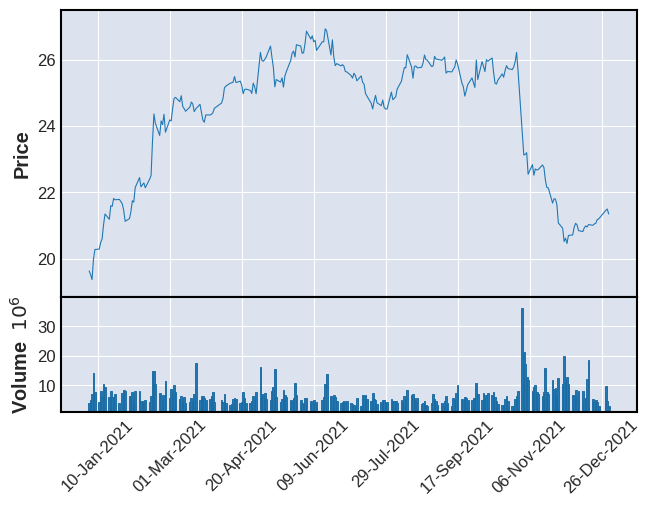

In [ ]:
mpf.plot(chart_data_df, type='line', volume=True, show_nontrading=True, datetime_format='%d-%b-%Y')